[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/NU-MSE-LECTURES/465_Computational_Microscopy_2026/blob/dev/Week_04/code_examples/example_04_cnn_basics.ipynb)

# Example 04: Building a Convolutional Neural Network (CNN)

## Overview
This notebook demonstrates how to build and train a Convolutional Neural Network (CNN) for image classification. We'll use a microscopy-inspired dataset approach with focus on:
1. **CNN Architecture Design** - Convolutional layers, pooling, and dense layers
2. **Model Training** - Using Keras Sequential API with optimization and regularization
3. **Performance Evaluation** - Metrics, confusion matrix, and learning curves
4. **Visualization** - Predictions on test data and feature map analysis

## Learning Objectives
- Understand the components of a CNN (convolution, pooling, activation functions)
- Learn to build CNN models using Keras Sequential API
- Train a CNN and monitor performance with callbacks
- Evaluate model performance on unseen data
- Visualize predictions and understand CNN decision-making
- Apply CNNs to microscopy image classification

In [3]:
# Install required packages
import subprocess
import sys

try:
    import tensorflow
    print("TensorFlow already installed")
except ImportError:
    print("Installing TensorFlow...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "tensorflow"])
    print("TensorFlow installed successfully")

# Colab setup
try:
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab. Installing requirements...")
    !pip install -q tensorflow scikit-learn matplotlib seaborn pandas
    print("Setup complete.")
except ImportError:
    IN_COLAB = False
    print("Not running in Google Colab.")

Installing TensorFlow...
TensorFlow installed successfully
Not running in Google Colab.


In [4]:
# Section 1: Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential, models
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Machine Learning utilities
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_recall_fscore_support

# Visualization
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
sns.set_style('whitegrid')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("All libraries imported successfully!")

TensorFlow version: 2.20.0
Keras version: 3.12.0
All libraries imported successfully!


---

## Part 1: Load and Preprocess Data

We'll use the MNIST dataset (28×28 pixel handwritten digits) as a starting point. This is similar to microscopy image classification tasks, with key preprocessing steps: normalization, reshaping, and one-hot encoding of labels.

Loading MNIST dataset...
Original training data shape: (60000, 28, 28)
Original test data shape: (10000, 28, 28)
Normalized training data shape: (60000, 28, 28)
Pixel value range: [0.00, 1.00]
Reshaped training data shape: (60000, 28, 28, 1)
Reshaped test data shape: (10000, 28, 28, 1)
Number of classes: 10
Encoded training labels shape: (60000, 10)


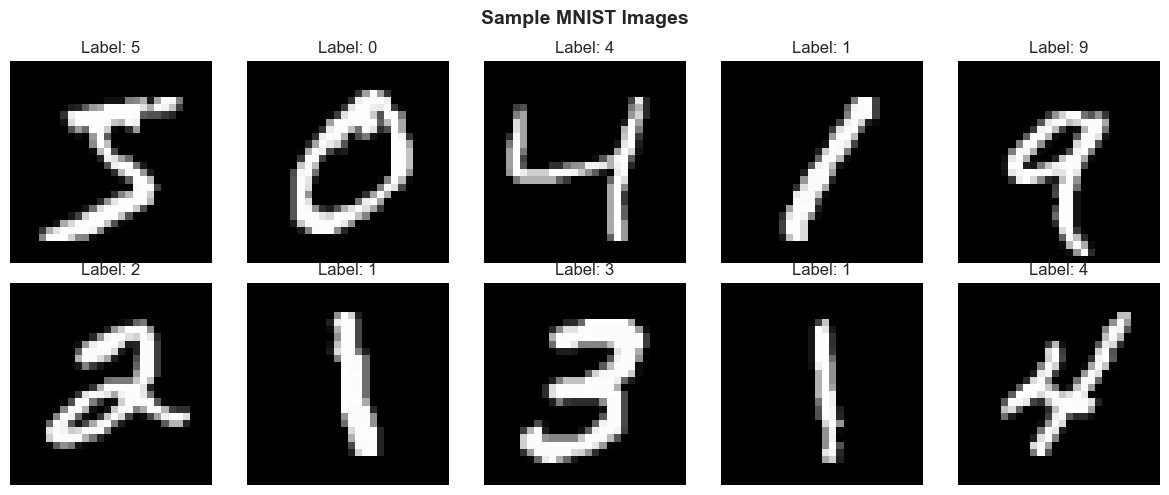

Data loading and preprocessing complete!


In [6]:
# Load MNIST dataset
print("Loading MNIST dataset...")
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(f"Original training data shape: {X_train.shape}")
print(f"Original test data shape: {X_test.shape}")

# Normalize pixel values to [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print(f"Normalized training data shape: {X_train.shape}")
print(f"Pixel value range: [{X_train.min():.2f}, {X_train.max():.2f}]")

# Reshape for CNN: (samples, height, width, channels)
# MNIST is grayscale, so add channel dimension
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

print(f"Reshaped training data shape: {X_train.shape}")
print(f"Reshaped test data shape: {X_test.shape}")

# One-hot encode labels
num_classes = 10
y_train_encoded = to_categorical(y_train, num_classes)
y_test_encoded = to_categorical(y_test, num_classes)

print(f"Number of classes: {num_classes}")
print(f"Encoded training labels shape: {y_train_encoded.shape}")

# Display sample images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('Sample MNIST Images', fontsize=14, fontweight='bold')

for idx, ax in enumerate(axes.flat):
    ax.imshow(X_train[idx].reshape(28, 28), cmap='gray')
    ax.set_title(f'Label: {y_train[idx]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

print("Data loading and preprocessing complete!")

---

## Part 2: Build the CNN Model

A CNN consists of several types of layers:
- **Convolutional Layers**: Extract spatial features using learnable filters
- **Activation Functions**: Introduce non-linearity (ReLU is standard)
- **Pooling Layers**: Reduce spatial dimensions and extract dominant features
- **Dropout**: Regularization to prevent overfitting
- **Dense Layers**: Fully connected layers for classification

The architecture we'll build:
```
Input (28, 28, 1)
    ↓
Conv2D(32 filters, 3×3) + ReLU
    ↓
MaxPooling2D (2×2)
    ↓
Conv2D(64 filters, 3×3) + ReLU
    ↓
MaxPooling2D (2×2)
    ↓
Conv2D(128 filters, 3×3) + ReLU
    ↓
Flatten
    ↓
Dense(128) + ReLU + Dropout(0.5)
    ↓
Dense(10) + Softmax
    ↓
Output (10 classes)
```

In [7]:
# Build the CNN Model using Sequential API
print("Building CNN model...")

model = Sequential([
    # First Convolutional Block
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    
    # Second Convolutional Block
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    
    # Third Convolutional Block
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    
    # Flatten and Dense Layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

print("\nModel Architecture:")
model.summary()

# Count total parameters
total_params = model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_params = total_params - trainable_params

print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {non_trainable_params:,}")

Building CNN model...

Model Architecture:


/Users/robertoreis/anaconda3/envs/matsci465/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,954 (949.04 KB)

 Trainable params: 242,250 (946.29 KB)

 Non-trainable params: 704 (2.75 KB)


Total parameters: 242,954
Trainable parameters: 242,250
Non-trainable parameters: 704


---

## Part 3: Compile the Model

Before training, we need to configure the model with:
- **Optimizer**: Adam (adaptive learning rate)
- **Loss Function**: Categorical crossentropy (for multi-class classification)
- **Metrics**: Accuracy to track performance

In [1]:
# Compile the Model
print("Compiling model...")

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully!")
print(f"Optimizer: Adam (lr=0.001)")
print(f"Loss function: Categorical Crossentropy")
print(f"Metrics: Accuracy")

Compiling model...


NameError: name 'model' is not defined

---

## Part 4: Train the Model

We'll train the CNN using the training data. Key training parameters:
- **Batch Size**: 128 samples per gradient update
- **Epochs**: 20 full passes through the training data
- **Validation Split**: 20% of training data for validation monitoring
- **Callbacks**: Early stopping and learning rate reduction for efficiency

Note: For faster training in this example, we use only 10,000 training samples.

In [9]:
# Use a subset of data for faster training (optional)
train_size = 10000
X_train_subset = X_train[:train_size]
y_train_subset = y_train_encoded[:train_size]

print(f"Training on {train_size} samples...")
print(f"Testing on {len(X_test)} samples...")

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# Train the model
print("\nTraining CNN model...")
history = model.fit(
    X_train_subset, y_train_subset,
    batch_size=128,
    epochs=20,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\nTraining complete!")

Training on 10000 samples...
Testing on 10000 samples...

Training CNN model...
Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.7326 - loss: 0.8904 - val_accuracy: 0.1105 - val_loss: 3.4201 - learning_rate: 0.0010
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9095 - loss: 0.2977 - val_accuracy: 0.1105 - val_loss: 4.8686 - learning_rate: 0.0010
Epoch 3/20
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9401 - loss: 0.2012
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9405 - loss: 0.1981 - val_accuracy: 0.1105 - val_loss: 5.7441 - learning_rate: 0.0010
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9532 - loss: 0.1587 - val_accuracy: 0.1105 - val_loss: 4.8482 - learning_rate: 5.0000e-04
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.

Training complete!


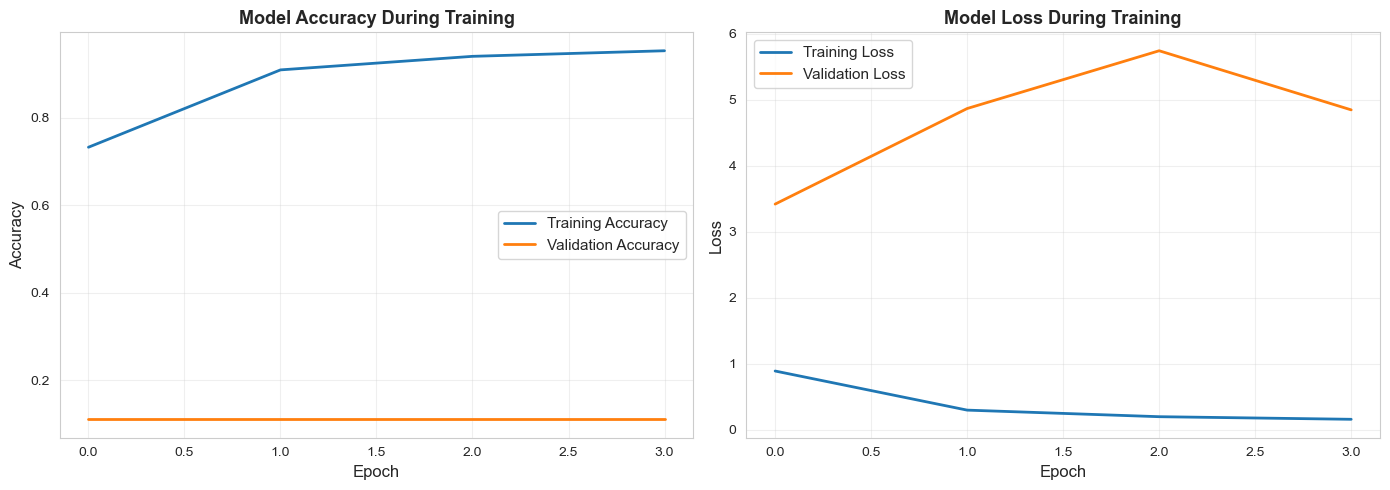


Training Summary:
Final Training Accuracy: 0.9532
Final Validation Accuracy: 0.1105
Final Training Loss: 0.1587
Final Validation Loss: 4.8482
Total Epochs Trained: 4


In [10]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy During Training', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Model Loss During Training', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print training summary
print("\nTraining Summary:")
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print(f"Total Epochs Trained: {len(history.history['loss'])}")

---

## Part 5: Evaluate Model Performance

We'll evaluate the trained CNN on the test set and compute various metrics including accuracy, precision, recall, and F1-score. We'll also visualize the confusion matrix.

Evaluating model on test set...

Test Set Performance:
Test Loss: 3.3913
Test Accuracy: 0.1135

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.11      1.00      0.20      1135
           2       0.00      0.00      0.00      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.11     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.11      0.02     10000


Per-Class Performance Metrics:
Class  Precision    Recall       F1-Score     Support   
------------------------

/Users/robertoreis/anaconda3/envs/matsci465/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/robertoreis/anaconda3/envs/matsci465/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/robertoreis/anaconda3/envs/matsci465/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

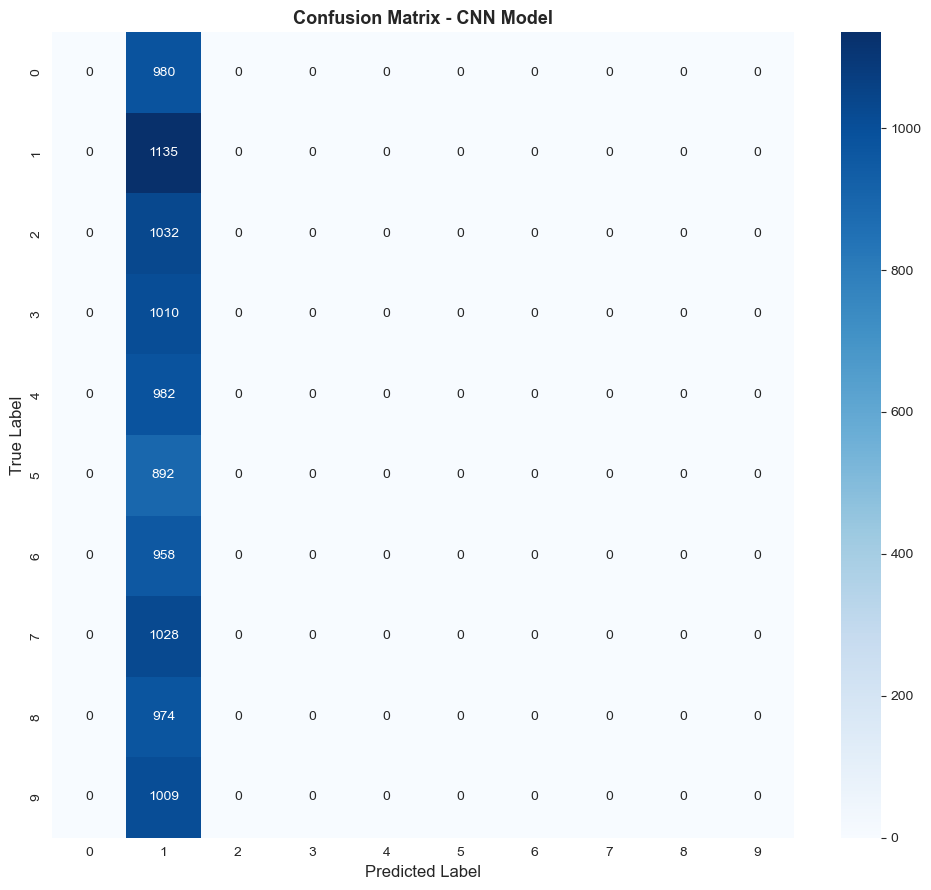

In [11]:
# Evaluate on test set
print("Evaluating model on test set...")
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)

print(f"\nTest Set Performance:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions
y_pred_probs = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=[str(i) for i in range(10)]))

# Per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average=None)

print("\nPer-Class Performance Metrics:")
print(f"{'Class':<6} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
print("-" * 50)
for i in range(10):
    print(f"{i:<6} {precision[i]:<12.4f} {recall[i]:<12.4f} {f1[i]:<12.4f} {support[i]:<10}")

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 9))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, ax=ax, 
            xticklabels=range(10), yticklabels=range(10))
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title('Confusion Matrix - CNN Model', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

---

## Part 6: Visualize Predictions

Let's visualize predictions on test images to understand where the model performs well and where it makes mistakes.

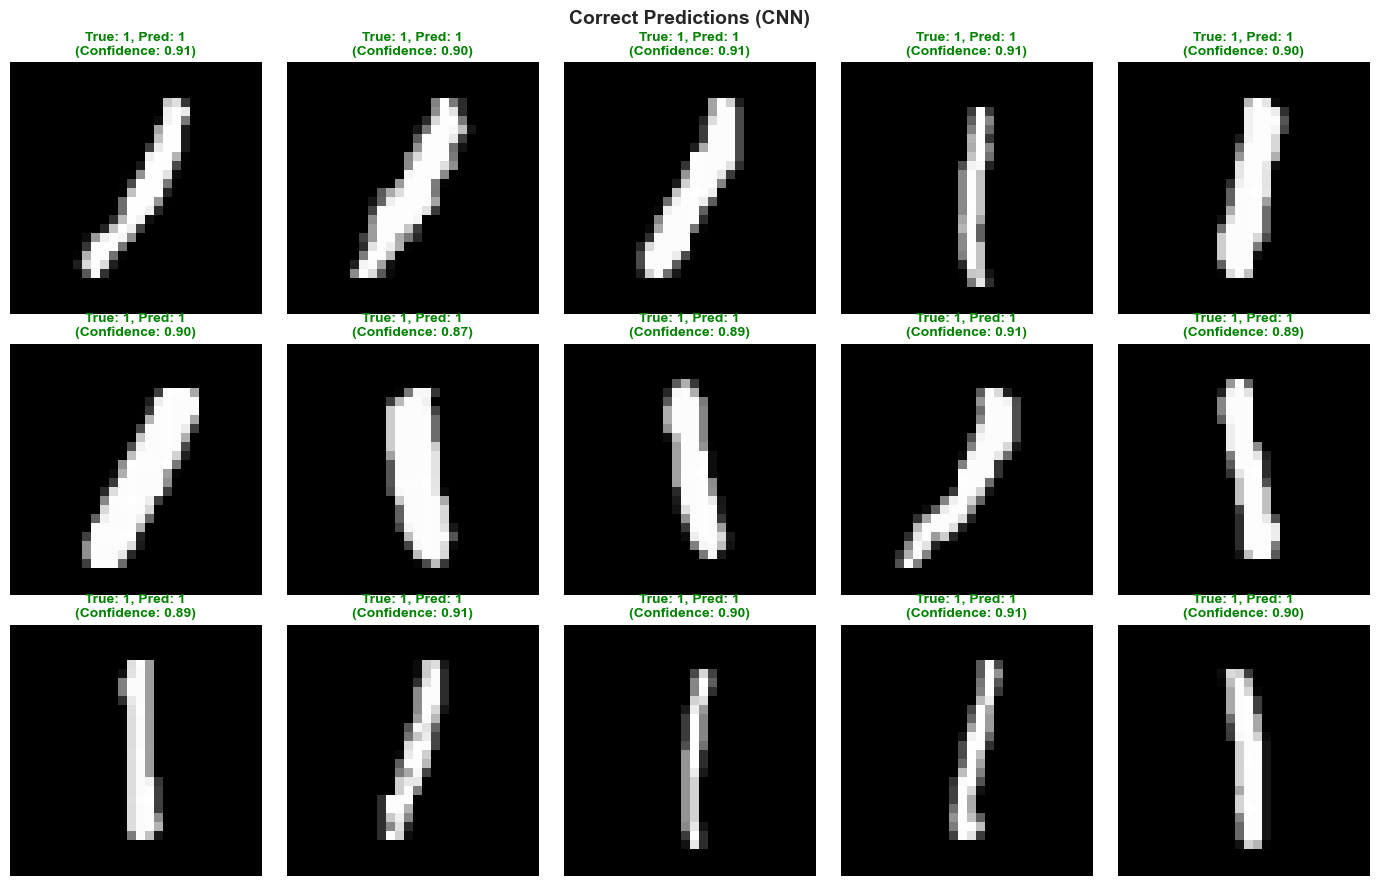

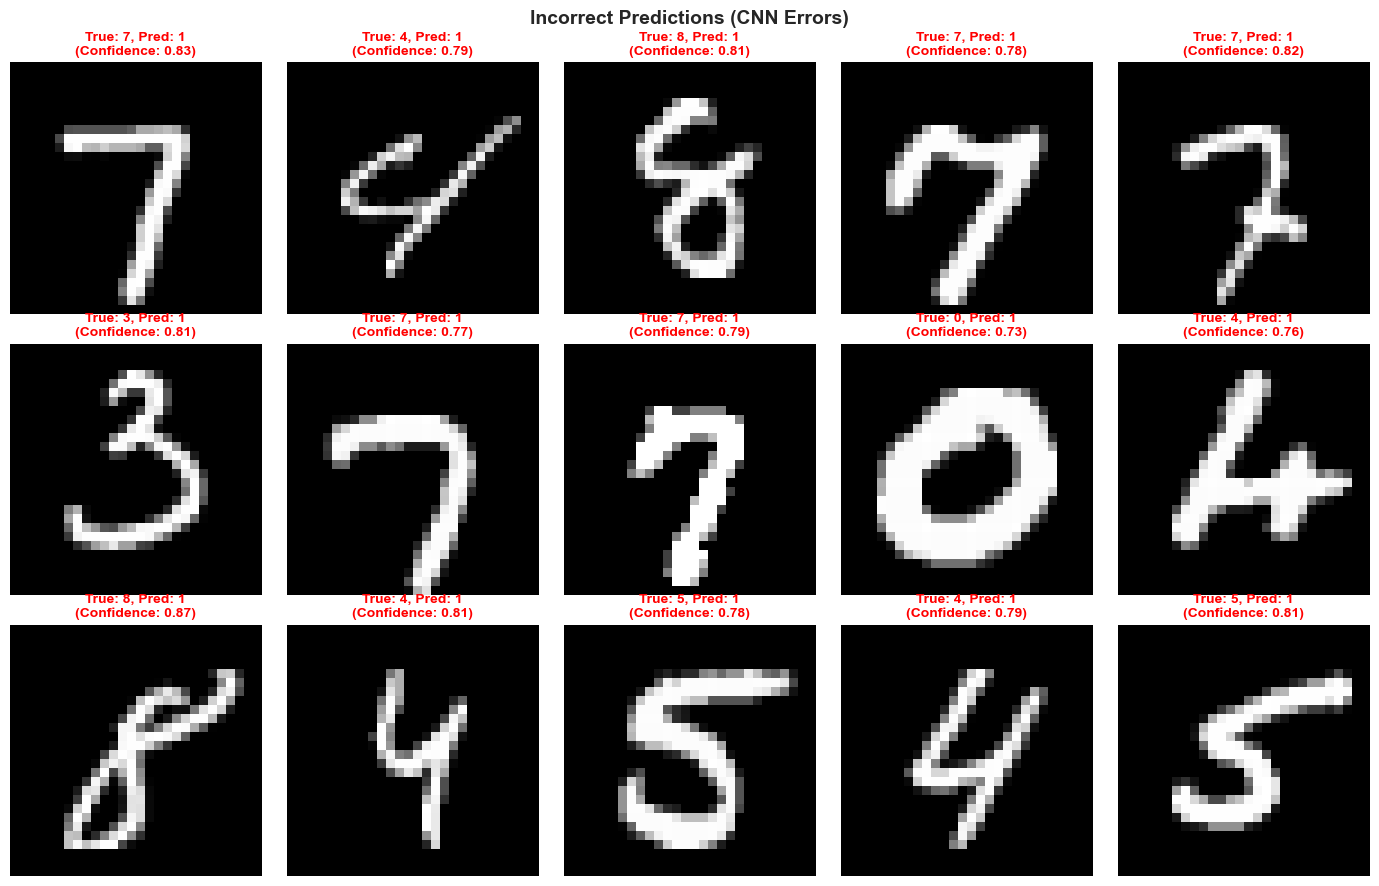

Total Correct Predictions: 1135 (11.35%)
Total Incorrect Predictions: 8865 (88.65%)


In [13]:
# Visualize correct predictions
fig, axes = plt.subplots(3, 5, figsize=(14, 9))
fig.suptitle('Correct Predictions (CNN)', fontsize=14, fontweight='bold')

correct_indices = np.where(y_pred == y_test)[0]
correct_sample_indices = np.random.choice(correct_indices, size=15, replace=False)

for idx, ax in enumerate(axes.flat):
    sample_idx = correct_sample_indices[idx]
    
    ax.imshow(X_test[sample_idx].reshape(28, 28), cmap='gray')
    true_label = y_test[sample_idx]
    pred_label = y_pred[sample_idx]
    confidence = np.max(y_pred_probs[sample_idx])
    
    ax.set_title(f'True: {true_label}, Pred: {pred_label}\n(Confidence: {confidence:.2f})', 
                 color='green', fontsize=10, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Visualize incorrect predictions (misclassifications)
fig, axes = plt.subplots(3, 5, figsize=(14, 9))
fig.suptitle('Incorrect Predictions (CNN Errors)', fontsize=14, fontweight='bold')

incorrect_indices = np.where(y_pred != y_test)[0]
if len(incorrect_indices) > 0:
    incorrect_sample_indices = np.random.choice(incorrect_indices, 
                                               size=min(15, len(incorrect_indices)), 
                                               replace=False)
    
    for idx, ax in enumerate(axes.flat):
        if idx < len(incorrect_sample_indices):
            sample_idx = incorrect_sample_indices[idx]
            
            ax.imshow(X_test[sample_idx].reshape(28, 28), cmap='gray')
            true_label = y_test[sample_idx]
            pred_label = y_pred[sample_idx]
            confidence = np.max(y_pred_probs[sample_idx])
            
            ax.set_title(f'True: {true_label}, Pred: {pred_label}\n(Confidence: {confidence:.2f})', 
                         color='red', fontsize=10, fontweight='bold')
            ax.axis('off')
        else:
            ax.axis('off')
else:
    print("No incorrect predictions found!")
    for ax in axes.flat:
        ax.axis('off')

plt.tight_layout()
plt.show()

print(f"Total Correct Predictions: {len(correct_indices)} ({100*len(correct_indices)/len(y_test):.2f}%)")
print(f"Total Incorrect Predictions: {len(incorrect_indices)} ({100*len(incorrect_indices)/len(y_test):.2f}%)")

---

## Part 7: Feature Visualization and Advanced Analysis

Let's extract and visualize the learned features (convolutional filters) from the first layer to understand what patterns the CNN learns.

First Conv Layer Filter Shape: (3, 3, 1, 32)
Number of filters: 32
Filter size: 3×3


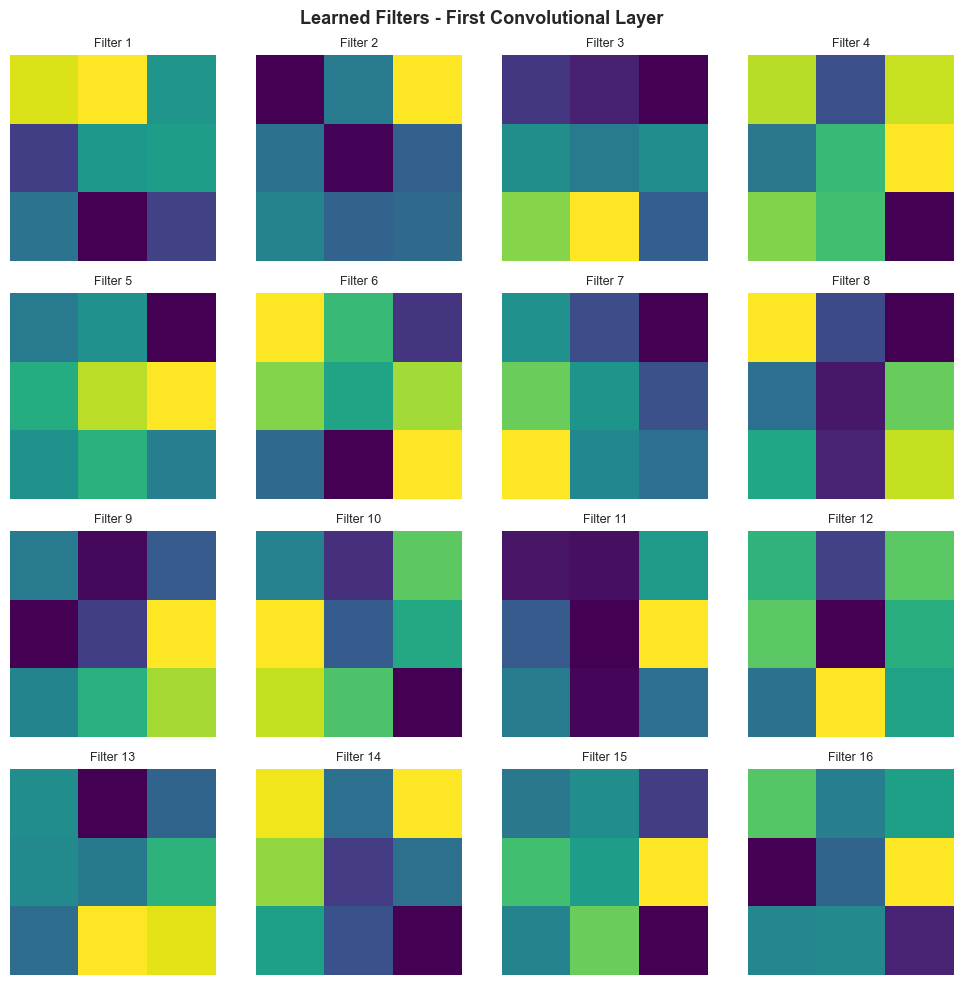


Activation Map Shape: (1, 26, 26, 32)


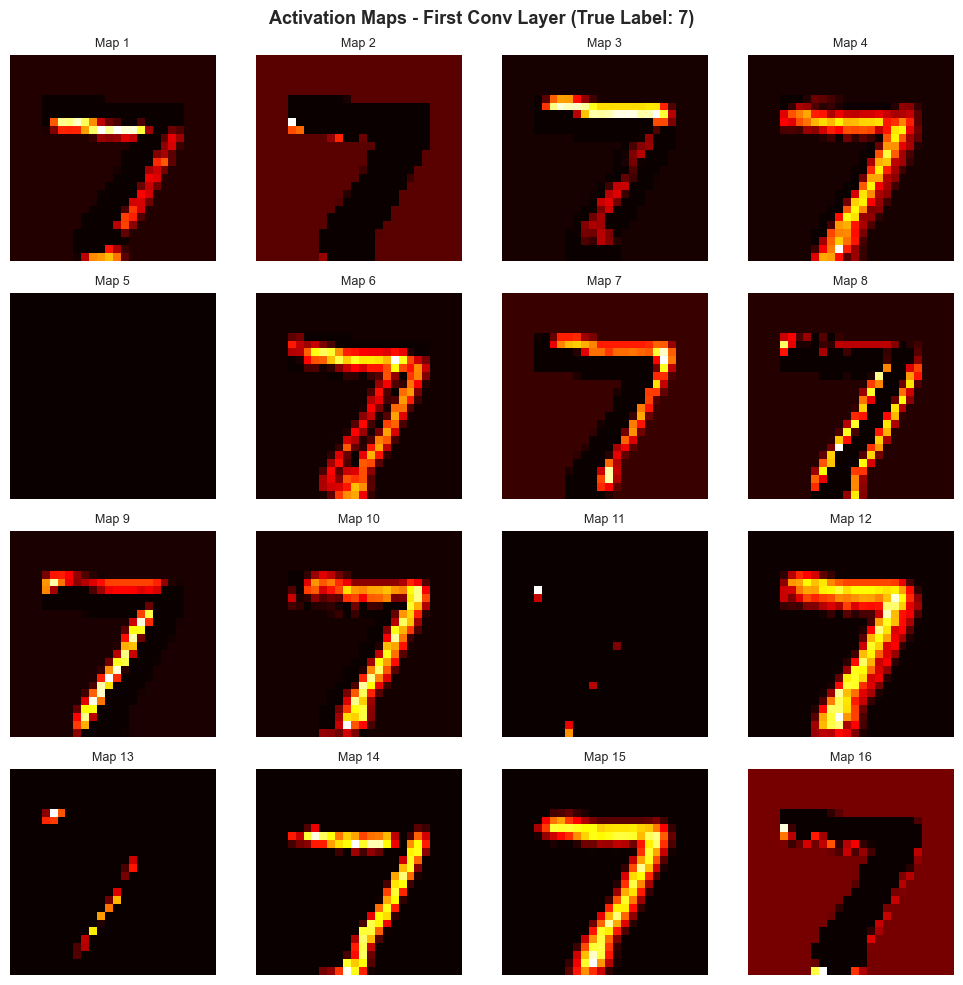


✓ Feature visualization complete!


In [16]:
# Extract and visualize learned filters from the first convolutional layer
first_layer_weights = model.layers[0].get_weights()[0]

print(f"First Conv Layer Filter Shape: {first_layer_weights.shape}")
print(f"Number of filters: {first_layer_weights.shape[-1]}")
print(f"Filter size: {first_layer_weights.shape[0]}×{first_layer_weights.shape[1]}")

# Normalize filters for visualization
filters_normalized = (first_layer_weights - first_layer_weights.min()) / \
                     (first_layer_weights.max() - first_layer_weights.min())

# Plot first 16 filters
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle('Learned Filters - First Convolutional Layer', fontsize=13, fontweight='bold')

for idx, ax in enumerate(axes.flat):
    filter_img = filters_normalized[:, :, 0, idx]
    ax.imshow(filter_img, cmap='viridis')
    ax.set_title(f'Filter {idx+1}', fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Visualize activation maps for a sample image
sample_image = X_test[0:1]

# Forward pass through first conv layer
activations = model.layers[0](sample_image).numpy()

print(f"\nActivation Map Shape: {activations.shape}")

# Plot activation maps
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle(f'Activation Maps - First Conv Layer (True Label: {y_test[0]})', 
             fontsize=13, fontweight='bold')

for idx, ax in enumerate(axes.flat):
    activation_map = activations[0, :, :, idx]
    ax.imshow(activation_map, cmap='hot')
    ax.set_title(f'Map {idx+1}', fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()

print("\n✓ Feature visualization complete!")

---

## Part 8: Key Concepts and Extensions

### CNN Architecture Principles:
1. **Convolutional Layers**: Detect local patterns (edges, textures, shapes)
2. **Pooling Layers**: Reduce dimensionality and extract dominant features
3. **Batch Normalization**: Stabilizes training and improves convergence
4. **Dropout**: Prevents overfitting by randomly deactivating neurons
5. **ReLU Activation**: Introduces non-linearity

### For Microscopy Applications:
- **Data Augmentation**: Rotation, translation, scaling for robustness
- **Transfer Learning**: Use pre-trained models (ResNet, VGG) on large datasets
- **U-Net Architecture**: Excellent for segmentation tasks
- **Physics-Informed Networks**: Incorporate domain knowledge for atomic-level analysis

### Next Steps:
- Experiment with different architectures (deeper networks, different layer configurations)
- Apply data augmentation for improved robustness
- Use transfer learning with pre-trained models
- Implement for your specific microscopy application
- Compare with classical ML methods (Random Forest, SVM)

In [17]:
# Example: Simple architecture comparison
print("\n" + "="*60)
print("ARCHITECTURE VARIANTS AND COMPARISON")
print("="*60 + "\n")

# Simple shallow CNN
simple_cnn = Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(10, activation='softmax')
])

# Medium CNN (our original model - already built)

# More complex CNN
complex_cnn = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

# Compare architectures
architectures = {
    'Simple CNN': simple_cnn,
    'Medium CNN (Used)': model,
    'Complex CNN': complex_cnn
}

print("Architecture Comparison:")
print(f"{'Architecture':<20} {'Parameters':<15} {'Trainable':<15}")
print("-" * 50)

for name, arch in architectures.items():
    total_params = arch.count_params()
    print(f"{name:<20} {total_params:<15,} {total_params:<15,}")

print("\n✓ Notebook completed successfully!")
print("Feel free to experiment with different architectures and hyperparameters.")


ARCHITECTURE VARIANTS AND COMPARISON

Architecture Comparison:
Architecture         Parameters      Trainable      
--------------------------------------------------
Simple CNN           27,210          27,210         
Medium CNN (Used)    242,954         242,954        
Complex CNN          176,746         176,746        

✓ Notebook completed successfully!
Feel free to experiment with different architectures and hyperparameters.


/Users/robertoreis/anaconda3/envs/matsci465/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
